In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import OrderedDict

#remove warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
#get player teams into dataframe from player_teams.csv
player_teams = pd.read_csv('../basketballPlayoffs/players_teams.csv')

#get player teams into dataframe from player_teams.csv
coaches = pd.read_csv('../basketballPlayoffs/coaches.csv')

#teams match up results (only post is available)
series_post = pd.read_csv('../basketballPlayoffs/series_post.csv')

#team stats in playoff
teams_post = pd.read_csv('../basketballPlayoffs/teams_post.csv')

#player csv
players = pd.read_csv('../basketballPlayoffs/players.csv')

#awards csv
awards_players = pd.read_csv('../basketballPlayoffs/awards_players.csv')

#teams csv
teams = pd.read_csv('../basketballPlayoffs/teams.csv')

#remove all columns starting with "lgID" from all dataframes
for df in [player_teams, coaches, series_post, teams_post, players, awards_players, teams]:
    for col in df.columns:
        if col.startswith('lgID'):
            df.drop(col, axis=1, inplace=True)

#drop divID column from teams
teams.drop('divID', axis=1, inplace=True)


In [4]:
# Assuming you have a column 'year' to sort by
player_teams = player_teams.sort_values(by=['playerID', 'year'])
player_teams['career_year'] = player_teams.groupby('playerID').cumcount() + 1

def compute_percentage(numerator, denominator):
    return round(numerator.divide(denominator).where(denominator != 0, 0.0)*100,2)

# Regular Season Percentages
player_teams['ft%'] = compute_percentage(player_teams['ftMade'], player_teams['ftAttempted'])
player_teams['fg%'] = compute_percentage(player_teams['fgMade'], player_teams['fgAttempted'])
player_teams['three%'] = compute_percentage(player_teams['threeMade'], player_teams['threeAttempted'])
player_teams['gs%'] = compute_percentage(player_teams['GS'], player_teams['GP'])

# Playoffs Percentages
player_teams['Postft%'] = compute_percentage(player_teams['PostftMade'], player_teams['PostftAttempted'])
player_teams['Postfg%'] = compute_percentage(player_teams['PostfgMade'], player_teams['PostfgAttempted'])
player_teams['Postthree%'] = compute_percentage(player_teams['PostthreeMade'], player_teams['PostthreeAttempted'])
player_teams['Postgs%'] = compute_percentage(player_teams['PostGS'], player_teams['PostGP'])

#effective field goal percentage
player_teams['efg%'] = compute_percentage(player_teams['fgMade'] + 0.5 * player_teams['threeMade'], player_teams['fgAttempted']) * 2

#true shooting percentage
player_teams['ts%'] = compute_percentage(player_teams['points'], 2 * (player_teams['fgAttempted'] + 0.44 * player_teams['ftAttempted'])) * 2

#per game stats
#if pos contains G, then multiply by assists by 1.5, if contains C, then multiply by rebounds by 1.5, if contains F, then points by 1.5 (it may contain more than one letter ex: G-F )
player_teams['ppg'] = round(player_teams['points']/player_teams['GP'],2)
player_teams['rpg'] = round(player_teams['rebounds']/player_teams['GP'],2)
player_teams['apg'] = round(player_teams['assists']/player_teams['GP'],2)
player_teams['spg'] = round(player_teams['steals']/player_teams['GP'],2)
player_teams['bpg'] = round(player_teams['blocks']/player_teams['GP'],2)

#efficiency
player_teams['eff'] = player_teams['ppg'] + player_teams['rpg'] + player_teams['apg'] + player_teams['spg'] + player_teams['bpg'] - (player_teams['fgAttempted'] - player_teams['fgMade']) - (player_teams['ftAttempted'] - player_teams['ftMade']) - player_teams['turnovers']

#add pos column from players to player_teams, bioID is the same as playerID
player_teams = player_teams.merge(players[['bioID', 'pos']], left_on='playerID', right_on='bioID', how='left')


#remove the made and attempted columns
player_teams.drop([ 'threeMade', 'threeAttempted', 'PostftMade', 'PostftAttempted', 'PostfgMade', 'PostfgAttempted', 'PostthreeMade', 'PostthreeAttempted', 'PostGS', 'PostGP'], axis=1, inplace=True)

In [5]:
coaches['total_games'] = coaches['won']+ coaches['lost']
coaches['W%'] = compute_percentage(coaches['won'],coaches['total_games'])

coaches['total_p_games'] = coaches['post_wins']+ coaches['post_losses']
coaches['postW%'] = compute_percentage(coaches['post_wins'],coaches['total_p_games'])

#remove won and lost columns, and post_wins and post_losses
coaches.drop(['won','lost','post_wins','post_losses'], axis=1, inplace=True)

coaches.head()

,coachID,year,tmID,stint,total_games,W%,total_p_games,postW%
0,adamsmi01w,5,WAS,0,34,50.00,3,33.33
1,adubari99w,1,NYL,0,32,62.50,7,57.14
2,adubari99w,2,NYL,0,32,65.62,6,50.00
3,adubari99w,3,NYL,0,32,56.25,8,50.00
4,adubari99w,4,NYL,0,34,47.06,0,0.00


In [6]:
# Get all unique teams
unique_teams = set(series_post['tmIDWinner']).union(series_post['tmIDLoser'])

# Create all possible combinations of matchups (excluding self-matchups)
matchups = combinations(sorted(unique_teams), 2)

# Initialize the records for all matchups
records = OrderedDict(((team1, team2), {'t1winsvst2': 0, 't1lossesvst2': 0}) for team1, team2 in matchups)

# Update win-loss counts
for _, row in series_post.iterrows():
    winner, loser = row['tmIDWinner'], row['tmIDLoser']
    
    if (winner, loser) in records:
        records[(winner, loser)]['t1winsvst2'] += row['W']
        records[(winner, loser)]['t1lossesvst2'] += row['L']
    elif (loser, winner) in records:
        records[(loser, winner)]['t1lossesvst2'] += row['W']
        records[(loser, winner)]['t1winsvst2'] += row['L']

# Convert the OrderedDict to a DataFrame
team_matchups = pd.DataFrame([(k[0], k[1], v['t1winsvst2'], v['t1lossesvst2']) 
                              for k, v in records.items()],
                             columns=['team1', 'team2', 'wins', 'losses'])

# Calculate win probability
team_matchups['totalGames'] = team_matchups['wins'] + team_matchups['losses']
team_matchups['winProb'] = team_matchups.apply(
    lambda row: round((row['wins'] / row['totalGames'])*100,2) if row['totalGames'] != 0 else 50.0,
    axis=1
)

# Drop the totalGames column if it's not needed
team_matchups.drop('totalGames', axis=1, inplace=True)

team_matchups.head()


,team1,team2,wins,losses,winProb
0,ATL,CHA,0,0,50.0
1,ATL,CLE,0,0,50.0
2,ATL,CON,0,0,50.0
3,ATL,DET,0,2,0.0
4,ATL,HOU,0,0,50.0


In [7]:
# Group by team ID and sum wins and losses
post_result = teams_post.groupby('tmID').agg({
    'W': 'sum',
    'L': 'sum'
}).reset_index()


In [8]:
#remove players with no birthDate
players = players[players['birthDate'].notnull()]

#remove college and collegeOther columns

players.drop(['college', 'collegeOther', 'deathDate'], axis=1, inplace=True)

#print players with empty columns
players[players.isnull().any(axis=1)]

,bioID,pos,firstseason,lastseason,height,weight,birthDate
5,adamsmi01w,NaN,0,0,0.0,0,0000-00-00
6,adubari99w,NaN,0,0,0.0,0,0000-00-00
7,aglerbr99w,NaN,0,0,0.0,0,0000-00-00
15,allenso99w,NaN,0,0,0.0,0,0000-00-00
52,beckan99wc,NaN,0,0,0.0,0,0000-00-00
...,...,...,...,...,...,...,...
848,willifr99w,NaN,0,0,0.0,0,0000-00-00
849,willigr99w,NaN,0,0,0.0,0,0000-00-00
863,wintebr01w,NaN,0,0,0.0,0,0000-00-00
872,woolror01w,NaN,0,0,0.0,0,0000-00-00


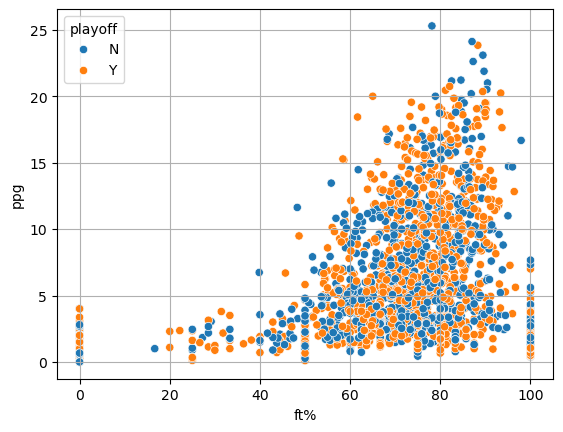

In [9]:
# Get the height of each player
player_height = players[['bioID', 'height']]

# Merge the player teams and player height dataframes (in the players_teams dataframe the id is playerID, in the players dataframe the id is bioID)
player_teams = player_teams.merge(player_height, left_on='playerID', right_on='bioID')

# Calculate points per minute
player_teams['ppg'] = player_teams['points'] / player_teams['GP']

#get the playoffs column from the teams dataframe, check by year and tmID
player_teams['playoff'] = player_teams.apply(
    lambda row: teams[teams['year'] == row['year']][teams['tmID'] == row['tmID']]['playoff'].values[0],
    axis=1
)

#remove outliers with height < 20

filtered_df = player_teams[player_teams['height'] > 20]

# Plot the scatter plot
sns.scatterplot(x='ft%', y='ppg', hue='playoff', data=filtered_df)
plt.grid(True)
plt.show()




     playerID                               award  year  next_season
0  thompti01w  All-Star Game Most Valuable Player     1            2
1  leslili01w  All-Star Game Most Valuable Player     2            3
2  leslili01w  All-Star Game Most Valuable Player     3            4
3  teaslni01w  All-Star Game Most Valuable Player     4            5
4  swoopsh01w  All-Star Game Most Valuable Player     6            7


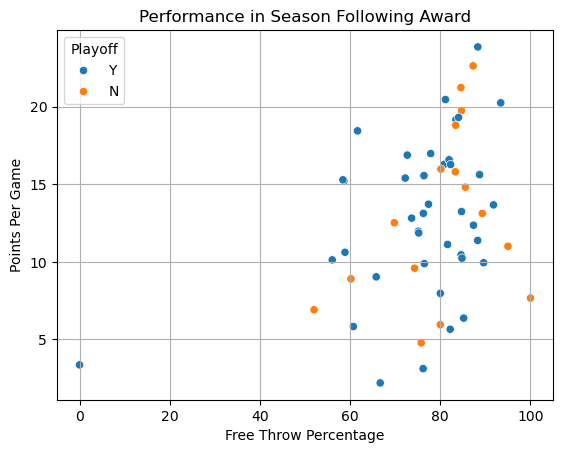

Percentage of players who won awards and made it to the playoffs the following year: 75.38%


In [10]:
# First, create a new column in 'awards_players' for the next season
awards_players['next_season'] = awards_players['year'] + 1

print(awards_players.head())

# Merge player_teams with awards_players on playerID and the next season
merged_df = player_teams.merge(awards_players[['playerID', 'award', 'next_season']], left_on=['playerID', 'year'], right_on=['playerID', 'next_season'])

# 2. Remove Outliers
filtered_df = merged_df[merged_df['height'] > 20]

# 3. Plot the scatter plot
sns.scatterplot(data=filtered_df, x='ft%', y='ppg', hue='playoff')
plt.title('Performance in Season Following Award')
plt.xlabel('Free Throw Percentage')
plt.ylabel('Points Per Game')
plt.grid(True)
plt.legend(title='Playoff')
plt.show()

#print the percentage of players who won awards and made it to the playoffs the following year
print('Percentage of players who won awards and made it to the playoffs the following year: {}%'.format(
    round(len(filtered_df[filtered_df['playoff'] == 'Y']) / len(filtered_df) * 100, 2)
))


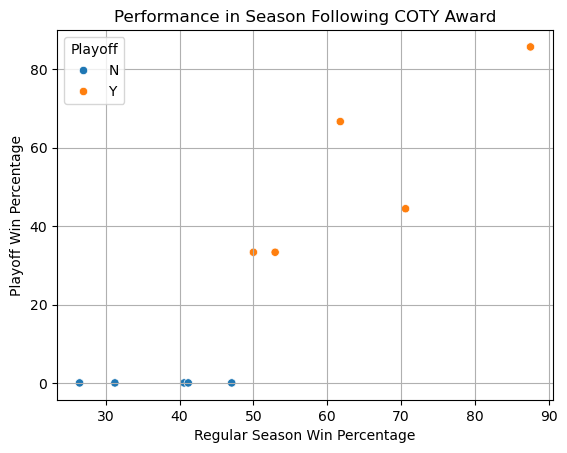

Percentage of coaches who won awards and made it to the playoffs the following year: 50.0%


In [11]:
#now do the same but for coaches, their awards are in the awards_players dataframe, but their teams are in the coaches dataframe and the playoffs are in the teams dataframe

# Merge coaches with awards_players on playerID and the next season, the playerID is coachID in the coaches dataframe
merged_df = coaches.merge(awards_players[['playerID', 'award', 'next_season']], left_on=['coachID', 'year'], right_on=['playerID', 'next_season'])

# 2. Remove Outliers
filtered_df = merged_df[merged_df['total_games'] > 0]

#get playoff column from teams dataframe
filtered_df['playoff'] = filtered_df.apply(
    lambda row: teams[teams['year'] == row['year']][teams['tmID'] == row['tmID']]['playoff'].values[0],
    axis=1
)

# 3. Plot the scatter plot
sns.scatterplot(data=filtered_df, x='W%', y='postW%', hue='playoff')
plt.title('Performance in Season Following COTY Award')
plt.xlabel('Regular Season Win Percentage')
plt.ylabel('Playoff Win Percentage')
plt.grid(True)
plt.legend(title='Playoff')
plt.show()

#print the percentage of coaches who won awards and made it to the playoffs the following year
print('Percentage of coaches who won awards and made it to the playoffs the following year: {}%'.format(
    round(len(filtered_df[filtered_df['playoff'] == 'Y']) / len(filtered_df) * 100, 2)
))

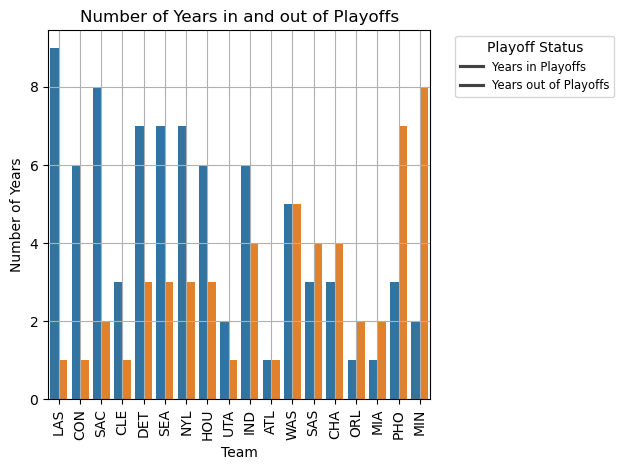

In [12]:
#plot a bar graph where x axis is the teams and y axis is the years they made it to the playoffs, make to bars per team, one for the number of years they did not make it to the playoffs and one for the number of years they did make it to the playoffs (you only need teams for this)

# Get the years each team made the playoffs
teams_playoffs = teams[teams['playoff'] == 'Y'].groupby('tmID').agg({
    'year': lambda x: list(x)
}).reset_index()

# Get the years each team did not make the playoffs

teams_no_playoffs = teams[teams['playoff'] == 'N'].groupby('tmID').agg({
    'year': lambda x: list(x)
}).reset_index()

# Get the number of years each team made the playoffs
teams_playoffs['num_years_playoffs'] = teams_playoffs['year'].apply(lambda x: len(x))

# Get the number of years each team did not make the playoffs
teams_no_playoffs['num_years_no_playoffs'] = teams_no_playoffs['year'].apply(lambda x: len(x))

# Merge the two dataframes
teams_merged = teams_playoffs.merge(teams_no_playoffs, on='tmID')

# Get the total number of years each team has been in the league
teams_merged['total_years'] = teams_merged['num_years_playoffs'] + teams_merged['num_years_no_playoffs']

# Get the percentage of years each team has made the playoffs
teams_merged['playoff_percentage'] = round((teams_merged['num_years_playoffs'] / teams_merged['total_years']) * 100, 2)

# Sort the values by playoff percentage
teams_merged.sort_values(by='playoff_percentage', ascending=False, inplace=True)

# Melt the data for plotting
teams_melted = pd.melt(teams_merged, id_vars='tmID', value_vars=['num_years_playoffs', 'num_years_no_playoffs'])
sns.barplot(data=teams_melted, x='tmID', y='value', hue='variable')
plt.title('Number of Years in and out of Playoffs')
plt.xlabel('Team')
plt.ylabel('Number of Years')
plt.grid(True)
plt.legend(title='Playoff Status', labels=['Years in Playoffs', 'Years out of Playoffs'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xticks(rotation=90)
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()

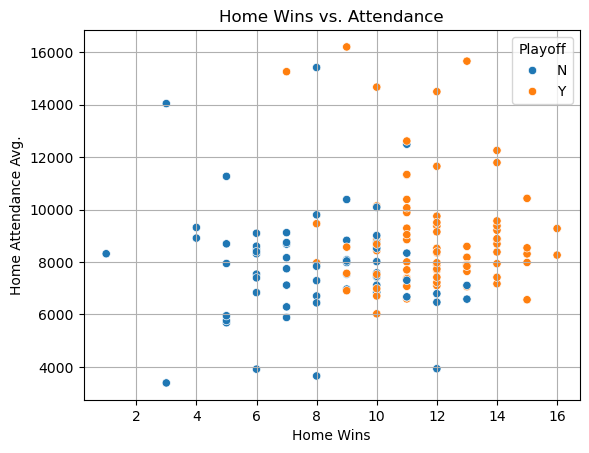

In [13]:
#plot a scatter graph for homeW in the x axis and attendance in the y axis, make the points different colors depending on the playoff column (you only need teams for this)

# Remove outliers
filtered_df = teams[teams['homeW'] > 0]

#get average attendance for each team
filtered_df['attend_avg'] = filtered_df.apply(
    lambda row: round((row['attend'] / (row['GP']-row['awayL']-row['awayW'])),2),
    axis=1
)

# Plot the scatter plot
sns.scatterplot(data=filtered_df, x='homeW', y='attend_avg', hue='playoff')
plt.title('Home Wins vs. Attendance')
plt.xlabel('Home Wins')
plt.ylabel('Home Attendance Avg.')
plt.grid(True)
plt.legend(title='Playoff')
plt.show()

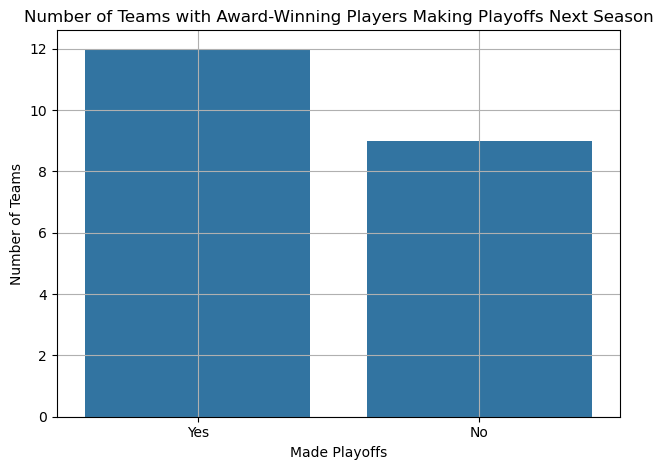

In [14]:

# Get the teams that had award winners the previous season
teams_awards = awards_players[awards_players['award'] != 'Coach of the Year']
teams_awards = teams_awards.merge(player_teams[['playerID', 'year', 'tmID']], on=['playerID', 'year'])

# Ensure that 'next_season' is an integer for merging
teams_awards['next_season'] = teams_awards['year'] + 1

# Merge the teams DataFrame with teams_awards to find out playoff status
teams_awards = teams_awards.merge(teams[['tmID', 'year', 'playoff']], left_on=['tmID', 'next_season'], right_on=['tmID', 'year'], how='left')

# Filter out entries where the next season exceeds the max year available
max_year = teams['year'].max()
teams_awards = teams_awards[teams_awards['next_season'] <= max_year]

# Drop unnecessary columns and duplicates
teams_awards = teams_awards[['tmID', 'playoff']].drop_duplicates()

# Now, count the number of teams that made and did not make the playoffs
teams_awards_playoffs = teams_awards[teams_awards['playoff'] == 'Y']
teams_awards_no_playoffs = teams_awards[teams_awards['playoff'] == 'N']

# Create the bar plot
sns.barplot(
    data=pd.DataFrame({
        'Playoff Status': ['Yes', 'No'],
        'Number of Teams': [len(teams_awards_playoffs), len(teams_awards_no_playoffs)]
    }), 
    x='Playoff Status', 
    y='Number of Teams'
)
plt.title('Number of Teams with Award-Winning Players Making Playoffs Next Season')
plt.xlabel('Made Playoffs')
plt.ylabel('Number of Teams')
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

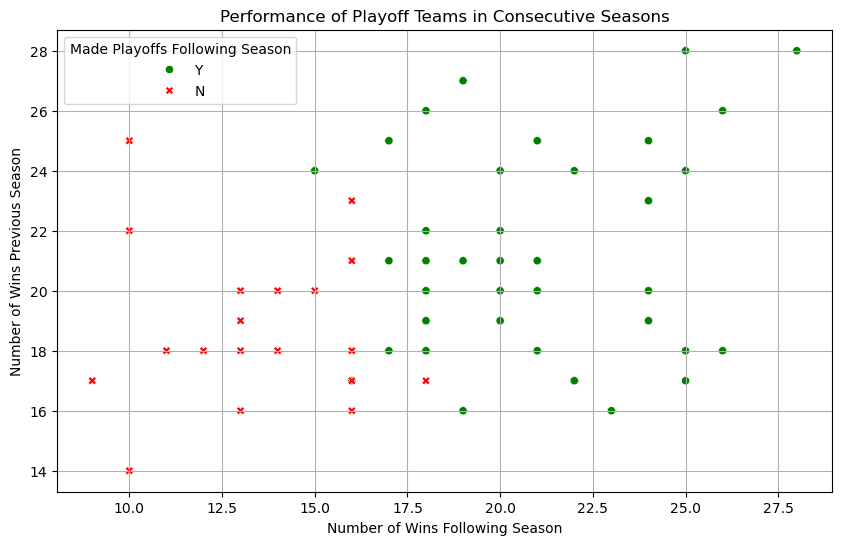

Percentage of teams that made the playoffs the previous season and made it the following season: 68.57%


In [15]:
#make a scatter graph for the teams that made the playoffs the previous season, x axis is the number of win the following season, y axis is the number of wins the previous season, make the points different colors depending on the playoff column (you only need teams for this) (check if the team exists in the following season, if not dont plot that dot)


# Find teams that made the playoffs
playoff_teams = teams[teams['playoff'] == 'Y']

# Initialize a list to collect data for each team
playoff_teams_next_year_list = []

# For each team that made the playoffs, check if they exist in the next season
for index, row in playoff_teams.iterrows():
    next_year = row['year'] + 1
    next_year_team = teams[(teams['tmID'] == row['tmID']) & (teams['year'] == next_year)]

    # If the team exists next year, add the info to the list
    if not next_year_team.empty:
        playoff_teams_next_year_list.append({
            'tmID': row['tmID'],
            'Previous Season Wins': row['won'],
            'Following Season Wins': next_year_team['won'].values[0],
            'Made Playoffs Next Season': next_year_team['playoff'].values[0]
        })

# Convert the list to a DataFrame
playoff_teams_next_year = pd.DataFrame(playoff_teams_next_year_list)

# Now that we have the data, let's plot it
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=playoff_teams_next_year,
    x='Following Season Wins',
    y='Previous Season Wins',
    hue='Made Playoffs Next Season',
    palette=['green', 'red'],  # Use appropriate colors for your dataset
    style='Made Playoffs Next Season'
)

plt.title('Performance of Playoff Teams in Consecutive Seasons')
plt.xlabel('Number of Wins Following Season')
plt.ylabel('Number of Wins Previous Season')
plt.legend(title='Made Playoffs Following Season')
plt.grid(True)
plt.show()

#percentage of teams that made the playoffs the previous season and made it the following season
print('Percentage of teams that made the playoffs the previous season and made it the following season: {}%'.format(
    round(len(playoff_teams_next_year[playoff_teams_next_year['Made Playoffs Next Season'] == 'Y']) / len(playoff_teams_next_year) * 100, 2)
))

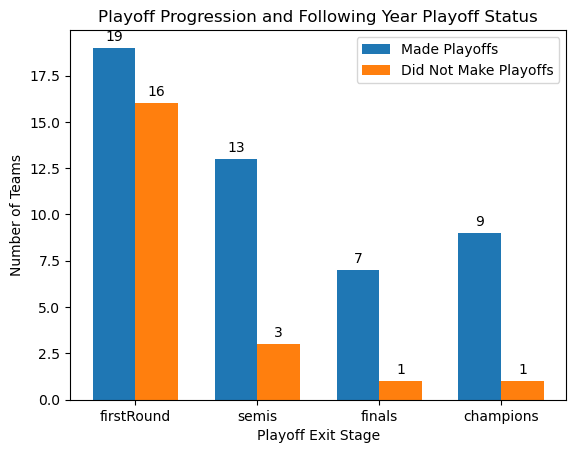

Percentage of teams that made it to the first round of the playoffs the following season: 54.29%
Percentage of teams that made it to the semi-finals of the playoffs the following season: 81.25%
Percentage of teams that made it to the finals of the playoffs the following season: 87.5%
Percentage of teams that were champions and made it to the playoffs the following season: 90.0%


In [16]:
df_teams = teams.copy()

# We will create a dictionary to hold our data
playoff_progression = {
    'firstRound': {'Made_Playoffs': 0, 'Did_Not_Make_Playoffs': 0},
    'semis': {'Made_Playoffs': 0, 'Did_Not_Make_Playoffs': 0},
    'finals': {'Made_Playoffs': 0, 'Did_Not_Make_Playoffs': 0},
    'champions': {'Made_Playoffs': 0, 'Did_Not_Make_Playoffs': 0}
}

# Ensure the data is sorted by team and year
df_teams.sort_values(by=['tmID', 'year'], inplace=True)

# Add a new column to determine if the team made the playoffs the following year
df_teams['made_playoff_next_year'] = df_teams.groupby('tmID')['playoff'].shift(-1)

# Iterate through each row to check playoff progression and next year's playoff status
for i, row in df_teams.iterrows():
    # Check if the team is present the following year
    team_next_year = df_teams[(df_teams['tmID'] == row['tmID']) & (df_teams['year'] == row['year'] + 1)]
    if team_next_year.empty:
        # Skip if the team does not exist next year
        continue

    # Update the dictionary based on the playoff progress and whether they made it next year
    for stage in ['firstRound', 'semis', 'finals']:
        if row[stage] == 'L':  # If they lost at this stage
            key = 'Made_Playoffs' if row['made_playoff_next_year'] == 'Y' else 'Did_Not_Make_Playoffs'
            playoff_progression[stage][key] += 1
            break  # Break the loop since we found the stage they lost at

    # Check if the team was a champion
    if row.get('finals') == 'W':  # If they won in the finals
        key = 'Made_Playoffs' if row['made_playoff_next_year'] == 'Y' else 'Did_Not_Make_Playoffs'
        playoff_progression['champions'][key] += 1

# Create lists to store the data for plotting
stages = ['firstRound', 'semis', 'finals', 'champions']
made_playoffs = [playoff_progression[stage]['Made_Playoffs'] for stage in stages]
did_not_make_playoffs = [playoff_progression[stage]['Did_Not_Make_Playoffs'] for stage in stages]

# X locations for the groups
ind = range(len(stages))

# Bar width
width = 0.35

fig, ax = plt.subplots()

# Create bars for teams that made the playoffs
made_playoffs_bars = ax.bar(ind, made_playoffs, width, label='Made Playoffs')

# Create bars for teams that did not make the playoffs
did_not_make_playoffs_bars = ax.bar([i + width for i in ind], did_not_make_playoffs, width, label='Did Not Make Playoffs')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Playoff Exit Stage')
ax.set_ylabel('Number of Teams')
ax.set_title('Playoff Progression and Following Year Playoff Status')
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(stages)
ax.legend()

# Function to add a label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call functions to add labels
autolabel(made_playoffs_bars)
autolabel(did_not_make_playoffs_bars)

# Show the plot
plt.show()

#print the percentage per playoff stage of teams that made it to the playoffs the following season
#first Round
print('Percentage of teams that made it to the first round of the playoffs the following season: {}%'.format(
    round(playoff_progression['firstRound']['Made_Playoffs'] / (playoff_progression['firstRound']['Made_Playoffs'] + playoff_progression['firstRound']['Did_Not_Make_Playoffs']) * 100, 2)
))

#semis
print('Percentage of teams that made it to the semi-finals of the playoffs the following season: {}%'.format(
    round(playoff_progression['semis']['Made_Playoffs'] / (playoff_progression['semis']['Made_Playoffs'] + playoff_progression['semis']['Did_Not_Make_Playoffs']) * 100, 2)
))

#finals
print('Percentage of teams that made it to the finals of the playoffs the following season: {}%'.format(
    round(playoff_progression['finals']['Made_Playoffs'] / (playoff_progression['finals']['Made_Playoffs'] + playoff_progression['finals']['Did_Not_Make_Playoffs']) * 100, 2)
))

#champions
print('Percentage of teams that were champions and made it to the playoffs the following season: {}%'.format(
    round(playoff_progression['champions']['Made_Playoffs'] / (playoff_progression['champions']['Made_Playoffs'] + playoff_progression['champions']['Did_Not_Make_Playoffs']) * 100, 2)
))




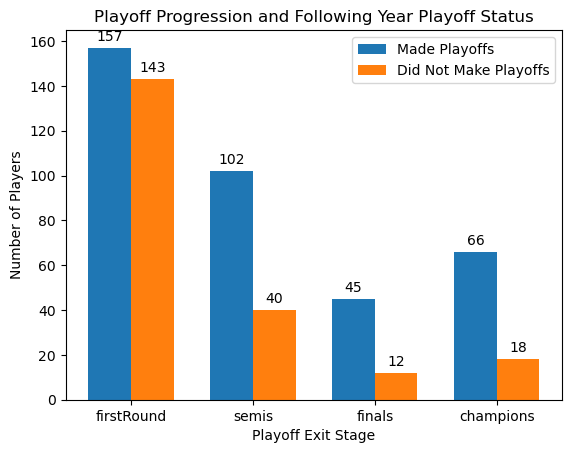

Probability of a player making the playoffs the following year given that they lost in the first round: 52.33%
Probability of a player making the playoffs the following year given that they lost in the semis: 71.83%
Probability of a player making the playoffs the following year given that they lost in the finals: 78.95%
Probability of a player making the playoffs the following year given that they won the championship: 78.57%


In [17]:
df_players_playoffs = player_teams.copy()

# Ensure year is int type
player_teams['year'] = player_teams['year'].astype(int)
df_teams['year'] = df_teams['year'].astype(int)

# Merge the columns into one column called playoff_progression
df_teams['champions'] = df_teams['finals'].apply(lambda x: 'W' if x == 'W' else '')

df_players_playoffs = df_players_playoffs.merge(
    df_teams[['tmID', 'year', 'firstRound', 'semis', 'finals', 'champions']],
    on=['tmID', 'year']
)

# Create a new column for playoff_progression
df_players_playoffs['playoff_progression'] = df_players_playoffs.apply(
    lambda row: 'firstRound' if row['firstRound'] == 'L' else
                'semis' if row['semis'] == 'L' else
                'finals' if row['finals'] == 'L' else
                'champions' if row['champions'] == 'W' else '',
    axis=1
)

#keep only some columns
df_players_playoffs = df_players_playoffs[['playerID', 'year', 'playoff_progression', 'playoff', 'tmID']]

df_players_playoffs['next_year'] = df_players_playoffs['year'] + 1

#remove years that are not in the teams dataframe
df_players_playoffs = df_players_playoffs[df_players_playoffs['next_year'].isin(df_teams['year'])]

# Define a function to retrieve the next year's playoff status for a player
def get_next_year_playoff(row, dataframe):
    next_year_data = dataframe[(dataframe['playerID'] == row['playerID']) & 
                               (dataframe['year'] == row['next_year'])]
    if not next_year_data.empty:
        return next_year_data.iloc[0]['playoff']
    else:
        return None  # or a suitable default value like np.nan

# Apply the function to each row
df_players_playoffs['playoff_nextYear'] = df_players_playoffs.apply(
    lambda row: get_next_year_playoff(row, df_players_playoffs), axis=1
)

#remove rows with None in playoff_nextYear
df_players_playoffs = df_players_playoffs[df_players_playoffs['playoff_nextYear'].notnull()]

#subdivide players into groups based on their playoff progression and playoff status the following year

firstRound_madePlayoffs = df_players_playoffs[(df_players_playoffs['playoff_progression'] == 'firstRound') & (df_players_playoffs['playoff_nextYear'] == 'Y')]
firstRound_noPlayoffs = df_players_playoffs[(df_players_playoffs['playoff_progression'] == 'firstRound') & (df_players_playoffs['playoff_nextYear'] == 'N')]

semis_madePlayoffs = df_players_playoffs[(df_players_playoffs['playoff_progression'] == 'semis') & (df_players_playoffs['playoff_nextYear'] == 'Y')]
semis_noPlayoffs = df_players_playoffs[(df_players_playoffs['playoff_progression'] == 'semis') & (df_players_playoffs['playoff_nextYear'] == 'N')]

finals_madePlayoffs = df_players_playoffs[(df_players_playoffs['playoff_progression'] == 'finals') & (df_players_playoffs['playoff_nextYear'] == 'Y')]
finals_noPlayoffs = df_players_playoffs[(df_players_playoffs['playoff_progression'] == 'finals') & (df_players_playoffs['playoff_nextYear'] == 'N')]

champions_madePlayoffs = df_players_playoffs[(df_players_playoffs['playoff_progression'] == 'champions') & (df_players_playoffs['playoff_nextYear'] == 'Y')]
champions_noPlayoffs = df_players_playoffs[(df_players_playoffs['playoff_progression'] == 'champions') & (df_players_playoffs['playoff_nextYear'] == 'N')]

#plot a bar graph for each group, y axis is the number of players, x axis is each of the groups, make two bars per group, one for the number of players that made the playoffs the following year and one for the number of players that did not make the playoffs the following year

# Create lists to store the data for plotting
stages = ['firstRound', 'semis', 'finals', 'champions']
made_playoffs = [len(firstRound_madePlayoffs), len(semis_madePlayoffs), len(finals_madePlayoffs), len(champions_madePlayoffs)]
did_not_make_playoffs = [len(firstRound_noPlayoffs), len(semis_noPlayoffs), len(finals_noPlayoffs), len(champions_noPlayoffs)]

# X locations for the groups
ind = range(len(stages))

# Bar width
width = 0.35

fig, ax = plt.subplots()

# Create bars for players that made the playoffs
made_playoffs_bars = ax.bar(ind, made_playoffs, width, label='Made Playoffs')

# Create bars for players that did not make the playoffs
did_not_make_playoffs_bars = ax.bar([i + width for i in ind], did_not_make_playoffs, width, label='Did Not Make Playoffs')

# Add some text for labels, title, and custom x-axis tick labels, etc.

ax.set_xlabel('Playoff Exit Stage')
ax.set_ylabel('Number of Players')
ax.set_title('Playoff Progression and Following Year Playoff Status')
ax.set_xticks([i + width / 2 for i in ind])

ax.set_xticklabels(stages)
ax.legend()

# Function to add a label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
# Call functions to add labels
autolabel(made_playoffs_bars)
autolabel(did_not_make_playoffs_bars)

# Show the plot
plt.show()

#print the probability of a player making the playoffs the following year given that they lost in the first round, semis, finals, and won the championship
print('Probability of a player making the playoffs the following year given that they lost in the first round: {}%'.format(
    round(len(firstRound_madePlayoffs) / (len(firstRound_madePlayoffs) + len(firstRound_noPlayoffs)) * 100, 2)
))

print('Probability of a player making the playoffs the following year given that they lost in the semis: {}%'.format(
    round(len(semis_madePlayoffs) / (len(semis_madePlayoffs) + len(semis_noPlayoffs)) * 100, 2)
))

print('Probability of a player making the playoffs the following year given that they lost in the finals: {}%'.format(
    round(len(finals_madePlayoffs) / (len(finals_madePlayoffs) + len(finals_noPlayoffs)) * 100, 2)
))

print('Probability of a player making the playoffs the following year given that they won the championship: {}%'.format(
    round(len(champions_madePlayoffs) / (len(champions_madePlayoffs) + len(champions_noPlayoffs)) * 100, 2)
))




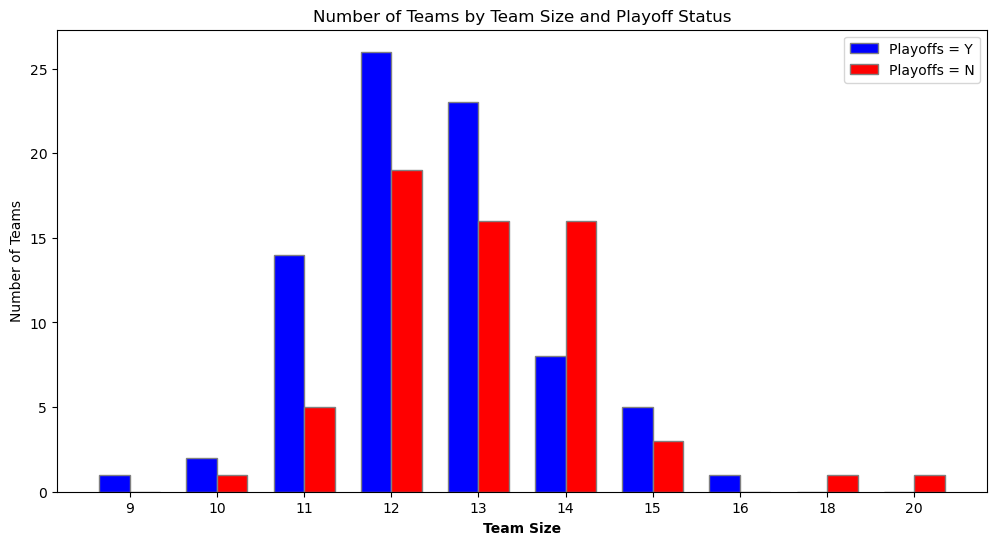

In [18]:
#plot in a bar chart the size of the teams that make the playoffs (only count stint <= 1)
# Get the teams that made the playoffs
teams_playoffs = teams

#just keep team and year columns
teams_playoffs = teams_playoffs[['tmID', 'year', 'playoff']]

#now get from player_teams the number of players of each team that have a stint <= 1 from that year
player_teams_stint = player_teams[player_teams['stint'] <= 1]

#merge the two dataframes
teams_playoffs = teams_playoffs.merge(player_teams_stint[['playerID', 'year', 'tmID']], on=['tmID', 'year'])

#remove duplicates
teams_playoffs = teams_playoffs.drop_duplicates()

#now join by  [tmID, year] and count the number of players
teams_playoffs = teams_playoffs.groupby(['tmID', 'year','playoff']).agg({
    'playerID': 'count'
}).reset_index()

#now change the name of the column playerID to num_players
teams_playoffs.rename(columns={'playerID': 'num_players'}, inplace=True)

#now join by [playoff, num_players] (remove tmID and year)
teams_playoffs = teams_playoffs.groupby(['playoff', 'num_players']).agg({
    'tmID': 'count'
}).reset_index()

#now change the name of the column tmID to num_teams
teams_playoffs.rename(columns={'tmID': 'num_teams'}, inplace=True)

# Assuming 'teams_playoffs' is the DataFrame with the aggregated data
# Split the data based on playoff status
playoff_teams = teams_playoffs[teams_playoffs['playoff'] == 'Y']
non_playoff_teams = teams_playoffs[teams_playoffs['playoff'] == 'N']

# Get a sorted array of unique team sizes
team_sizes = sorted(teams_playoffs['num_players'].unique())

# Create corresponding data for playoff and non-playoff teams
playoff_counts = [playoff_teams[playoff_teams['num_players'] == size]['num_teams'].values[0] if size in playoff_teams['num_players'].values else 0 for size in team_sizes]
non_playoff_counts = [non_playoff_teams[non_playoff_teams['num_players'] == size]['num_teams'].values[0] if size in non_playoff_teams['num_players'].values else 0 for size in team_sizes]

# Define the width of a bar and the positions for each group
bar_width = 0.35
r1 = np.arange(len(team_sizes))
r2 = [x + bar_width for x in r1]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(r1, playoff_counts, color='b', width=bar_width, edgecolor='grey', label='Playoffs = Y')
plt.bar(r2, non_playoff_counts, color='r', width=bar_width, edgecolor='grey', label='Playoffs = N')

# Add labels to the chart
plt.xlabel('Team Size', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(team_sizes))], team_sizes)
plt.ylabel('Number of Teams')
plt.title('Number of Teams by Team Size and Playoff Status')

# Create a legend
plt.legend()

# Show the chart
plt.show()

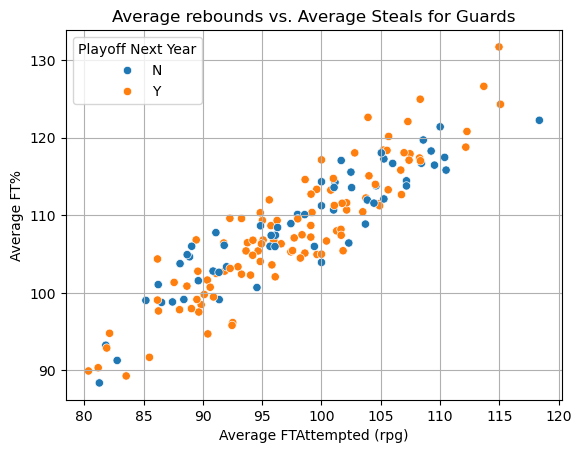

In [19]:
#plot the average points of players vs average asssts (only pos = G or G-F) (make it a scatter graph and the hue is the playoff column)

# Get the players that are guards
guards = player_teams#[player_teams['pos'].isin(['C', 'F-C'])]

#max year is 10
guards = guards[guards['year'] < 10]

#create column next_year
guards['next_year'] = guards['year'] + 1

# Assuming 'teams' is a DataFrame with a 'playoff' column, 'year', and 'tmID'.

# First, create a new DataFrame for teams in the next year with the relevant columns.
next_year_teams = teams[['tmID', 'year', 'playoff']].copy()
next_year_teams['year'] -= 1  # Adjust the year to match the 'guards' DataFrame.

# Merge the 'guards' DataFrame with the 'next_year_teams' DataFrame.
guards = pd.merge(guards, next_year_teams, how='left', left_on=['tmID', 'next_year'], right_on=['tmID', 'year'])
# After merging, there may be NaNs in 'playoff' column for teams or players that don't exist in the next year.

#drop NaN rows
guards = guards[guards['playoff_y'].notnull()]

#check rpg > 10
guards = guards[guards['fg%'] > 40]

guards = guards[guards['ft%'] > 80]

guards = guards[guards['fgAttempted'] > 100]
# Rename the 'playoff' column from the merge to 'playoff_nextYear'.
guards.rename(columns={'playoff_y': 'playoff_nextYear'}, inplace=True)

# Now you can plot the data.
sns.scatterplot(data=guards, x='efg%', y='ts%', hue='playoff_nextYear')
plt.title('Average rebounds vs. Average Steals for Guards')
plt.xlabel('Average FTAttempted (rpg)')
plt.ylabel('Average FT%')
plt.grid(True)
plt.legend(title='Playoff Next Year')
plt.show()



In [20]:
#calculate team stats
# ppg , rpg, apg, spg, bpg, eff, ft%, fg%, three%, gs%, efg%, ts%

teams['ppg'] = round(teams['o_pts']/teams['GP'],2)

teams['oppg'] = round(teams['d_pts']/teams['GP'],2)

teams['rpg'] = round(teams['tmTRB']/teams['GP'],2)

teams['apg'] = round(teams['o_asts']/teams['GP'],2)

teams['spg'] = round(teams['o_stl']/teams['GP'],2)

teams['bpg'] = round(teams['o_blk']/teams['GP'],2)

#average attend
teams['attend_avg'] = round(teams['attend'] / (teams['GP']-teams['awayL']-teams['awayW']),2)


#playoff next year

# Assuming 'teams' is a DataFrame with a 'playoff' column, 'year', and 'tmID'.

# First, create a new DataFrame for teams in the next year with the relevant columns.
next_year_teams = teams[['tmID', 'year', 'playoff']].copy()

next_year_teams['year'] -= 1 

#next_year column
teams['next_year'] = teams['year'] + 1

# Merge the 'teams' DataFrame with the 'next_year_teams' DataFrame.
teams = pd.merge(teams, next_year_teams, how='left', left_on=['tmID', 'next_year'], right_on=['tmID', 'year'])
# After merging, there may be NaNs in 'playoff' column for teams or players that don't exist in the next year.

#drop NaN rows
teams = teams[teams['playoff_y'].notnull()]

# Rename the 'playoff' column from the merge to 'playoff_nextYear'.
teams.rename(columns={'playoff_y': 'playoff_nextYear'}, inplace=True)


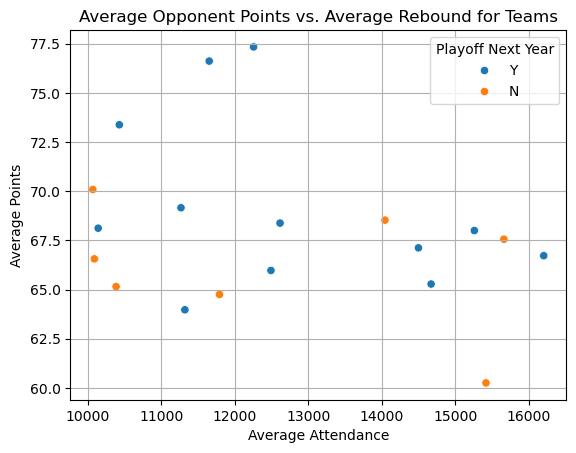

In [24]:
# Now you can plot the data
#rpg above 32

#teams with attend > 10000
teams = teams[teams['attend_avg'] > 10000]

sns.scatterplot(data=teams, x='attend_avg', y='ppg', hue='playoff_nextYear')
plt.title('Average Opponent Points vs. Average Rebound for Teams')
plt.xlabel('Average Attendance')
plt.ylabel('Average Points')
plt.grid(True)
plt.legend(title='Playoff Next Year')
plt.show()


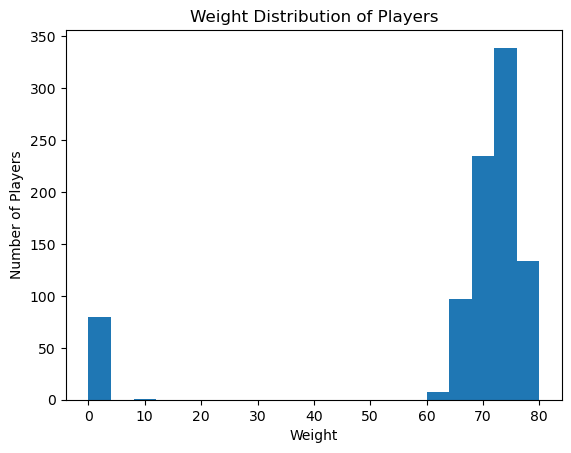

In [26]:
#plot the height and weights of players that made it to the playoffs the following year using players dataframe

players_weight = players['weight']
player_height = players['height']

#Plot the histogram

plt.hist(player_height, bins=20)
plt.title('Weight Distribution of Players')
plt.xlabel('Weight')
plt.ylabel('Number of Players')

plt.show()
